# 0. Importing Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from scipy.stats import zscore

# 1. Loading the Datasets

In [5]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: walmart_cleaned.csv     


In [6]:
data = pd.read_csv('/content/walmart_cleaned.csv')
data.head()

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


## 1.1 Description about the data set

In [7]:
data.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,421570.000000,211611.321278,122195.149363,0.000000,105782.250000,211603.500000,317424.750000,423285.000000
Store,421570.000000,22.200546,12.785297,1.000000,11.000000,22.000000,33.000000,45.000000
IsHoliday,421570.000000,0.070358,0.255750,0.000000,0.000000,0.000000,0.000000,1.000000
Dept,421570.000000,44.260317,30.492054,1.000000,18.000000,37.000000,74.000000,99.000000
Weekly_Sales,421570.000000,15981.258123,22711.183519,-4988.940000,2079.650000,7612.030000,20205.852500,693099.360000
Temperature,421570.000000,60.090059,18.447931,-2.060000,46.680000,62.090000,74.280000,100.140000
Fuel_Price,421570.000000,3.361027,0.458515,2.472000,2.933000,3.452000,3.738000,4.468000
MarkDown1,421570.000000,2590.074819,6052.385934,0.000000,0.000000,0.000000,2809.050000,88646.760000
MarkDown2,421570.000000,879.974298,5084.538801,-265.760000,0.000000,0.000000,2.200000,104519.540000
MarkDown3,421570.000000,468.087665,5528.873453,-29.100000,0.000000,0.000000,4.540000,141630.610000


## 1.2 Types of the data

In [8]:
pd.DataFrame(data.dtypes, columns=['Type']).T

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Type,int64,int64,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64


# 2. Data Preprocessing

## 2.1 Converting the Date column in Date Time Format

In [9]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = pd.to_datetime(data['Date']).dt.year
data['Month'] = pd.to_datetime(data['Date']).dt.month
data['Week'] = pd.to_datetime(data['Date']).dt.week
data['DayOfTheWeek'] = data['Date'].dt.dayofweek
data['Day'] = pd.to_datetime(data['Date']).dt.day

## 2.2 Cheaking NA values

In [10]:
data.isna().sum()

Unnamed: 0      0
Store           0
Date            0
IsHoliday       0
Dept            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Month           0
Week            0
DayOfTheWeek    0
Day             0
dtype: int64

## 2.3 Subsetting the data set

In [11]:
data.shape

(421570, 22)

In [12]:
df = data[['Date', 'IsHoliday', 'Dept', 'Weekly_Sales',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']]

## 2.4 Setting Date as Index

In [13]:
df.set_index('Date', inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   IsHoliday     421570 non-null  int64  
 1   Dept          421570 non-null  float64
 2   Weekly_Sales  421570 non-null  float64
 3   Temperature   421570 non-null  float64
 4   Fuel_Price    421570 non-null  float64
 5   MarkDown1     421570 non-null  float64
 6   MarkDown2     421570 non-null  float64
 7   MarkDown3     421570 non-null  float64
 8   MarkDown4     421570 non-null  float64
 9   MarkDown5     421570 non-null  float64
 10  CPI           421570 non-null  float64
 11  Unemployment  421570 non-null  float64
 12  Type          421570 non-null  int64  
 13  Size          421570 non-null  int64  
dtypes: float64(11), int64(3)
memory usage: 48.2 MB


# Anomaly Detection:
###                       Anomaly Detection is the technique of identifying rare events or observations which can raise suspicions by being statistically different from the rest of the observations. Such “anomalous” behaviour typically translates to some kind of a problem like a credit card fraud, failing machine in a server, a cyber attack, etc.
### An anomaly can be broadly categorized into three categories –


### Point Anomaly: A tuple in a dataset is said to be a Point Anomaly if it is far off from the rest of the data.
### Contextual Anomaly: An observation is a Contextual Anomaly if it is an anomaly because of the context of the observation.
### Collective Anomaly: A set of data instances help in finding an anomaly.

### Anomaly detection can be done using the concepts of Machine Learning. It can be done in the following ways –


### Supervised Anomaly Detection: This method requires a labeled dataset containing both normal and anomalous samples to construct a predictive model to classify future data points. The most commonly used algorithms for this purpose are supervised Neural Networks, Support Vector Machine learning, K-Nearest Neighbors Classifier, etc.

### Unsupervised Anomaly Detection: This method does require any training data and instead assumes two things about the data ie Only a small percentage of data is anomalous and Any anomaly is statistically different from the normal samples. Based on the above assumptions, the data is then clustered using a similarity measure and the data points which are far off from the cluster are considered to be anomalies.

## 3. Fitting Base Models

In [15]:
X = df.values

In [16]:
from sklearn.neighbors import NearestNeighbors

In [17]:
nbrs = NearestNeighbors(n_neighbors = 3)
# fit model
nbrs.fit(X)

NearestNeighbors(n_neighbors=3)

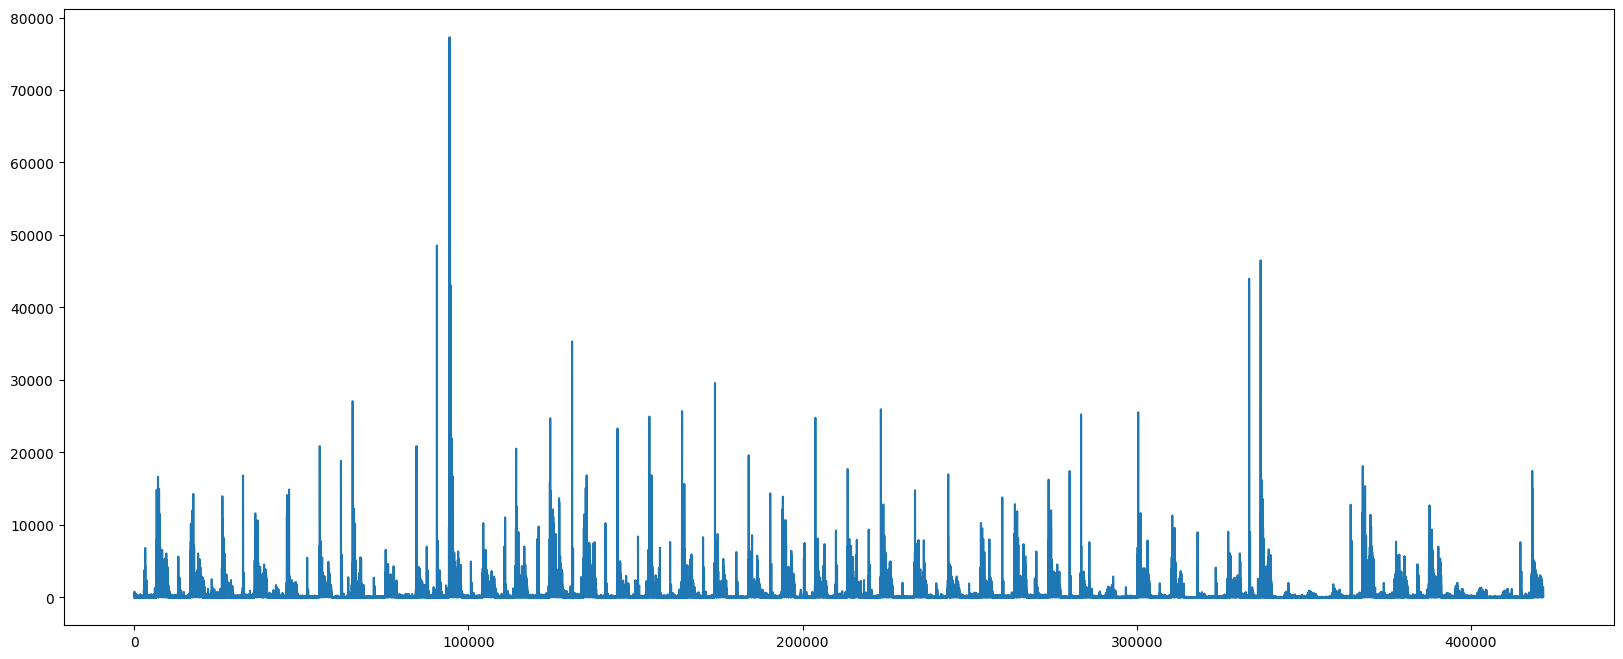

In [18]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(X)
# plot mean of k-distances of each observation
plt.figure(figsize=(20,8))
plt.plot(distances.mean(axis =1))

In [19]:
# visually determine cutoff values > 35000
outlier_index = np.where(distances.mean(axis = 1) > 35000)
#outlier_index

In [20]:
# filter outlier values
outlier_values = data.iloc[outlier_index]
outlier_values

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week,DayOfTheWeek,Day
90609,90960,10,2010-11-26,1,72.0,693099.36,55.33,3.162,0.00,0.00,...,0.00,126.669267,9.003,2,126512,2010,11,47,4,26
94385,94736,10,2011-11-25,1,72.0,630999.19,60.68,3.760,174.72,329.00,...,1009.98,129.836400,7.874,2,126512,2011,11,47,4,25
94743,95094,10,2011-12-30,1,72.0,156431.46,48.92,3.428,7676.36,104519.54,...,3732.93,130.071032,7.874,2,126512,2011,12,52,4,30
131045,131552,14,2010-11-26,1,72.0,474330.10,46.15,3.039,0.00,0.00,...,0.00,182.783277,8.724,3,200898,2010,11,47,4,26
333606,334932,35,2010-11-26,1,72.0,627962.93,46.67,3.039,0.00,0.00,...,0.00,136.689571,8.763,2,103681,2010,11,47,4,26
337045,338371,35,2011-11-25,1,72.0,649770.18,47.88,3.492,1333.24,0.00,...,6386.86,140.421786,8.745,2,103681,2011,11,47,4,25


## 3.2 Anomaly Detection Using Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
df3 = df.copy()

In [ ]:
model=IsolationForest(n_estimators=1000,max_samples='auto',contamination=float(0.2),max_features=14)
model.fit(df)

IsolationForest(contamination=0.2, max_features=14, n_estimators=1000)

In [ ]:
df3['scores']=model.decision_function(df)
df3['anomaly']=model.predict(df)
df3.head(20)

,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,scores,anomaly
Date,,,,,,,,,,,,,,,,
2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315,0.039623,1
2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315,0.063606,1
2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315,0.060636,1
2010-02-05,0,45.0,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315,0.062936,1
2010-02-05,0,28.0,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315,0.064509,1
2010-02-05,0,79.0,46729.77,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315,0.036699,1
2010-02-05,0,55.0,21249.31,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315,0.057798,1
2010-02-05,0,5.0,32229.38,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315,0.043354,1
2010-02-05,0,58.0,7659.97,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315,0.061806,1


In [ ]:
df3[df3['anomaly']== -1]

,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,scores,anomaly
Date,,,,,,,,,,,,,,,,
2010-02-05,0,95.0,106690.06,42.31,2.572,0.0,0.00,0.00,0.00,0.0,211.096358,8.106,3,151315,-0.008555,-1
2010-02-05,0,92.0,139884.94,42.31,2.572,0.0,0.00,0.00,0.00,0.0,211.096358,8.106,3,151315,-0.020956,-1
2010-02-12,1,3.0,10887.84,38.51,2.548,0.0,0.00,0.00,0.00,0.0,211.242170,8.106,3,151315,-0.029264,-1
2010-02-12,1,79.0,36080.86,38.51,2.548,0.0,0.00,0.00,0.00,0.0,211.242170,8.106,3,151315,-0.038587,-1
2010-02-12,1,46.0,18826.47,38.51,2.548,0.0,0.00,0.00,0.00,0.0,211.242170,8.106,3,151315,-0.021856,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-21,0,94.0,5008.65,65.32,4.038,8452.2,92.28,63.24,2376.38,8670.4,191.856704,8.684,2,118221,-0.008824,-1
2012-09-21,0,83.0,714.42,65.32,4.038,8452.2,92.28,63.24,2376.38,8670.4,191.856704,8.684,2,118221,-0.004752,-1
2012-09-21,0,82.0,11093.46,65.32,4.038,8452.2,92.28,63.24,2376.38,8670.4,191.856704,8.684,2,118221,-0.003936,-1


In [ ]:
# percantage. of Outliers
df3[df3['anomaly']== -1].shape[0]/df.shape[0]*100

20.0

In [ ]:
df3 = df3[df3['anomaly']== -1]

In [ ]:
df3

,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,scores,anomaly
Date,,,,,,,,,,,,,,,,
2010-02-05,0,95.0,106690.06,42.31,2.572,0.0,0.00,0.00,0.00,0.0,211.096358,8.106,3,151315,-0.008555,-1
2010-02-05,0,92.0,139884.94,42.31,2.572,0.0,0.00,0.00,0.00,0.0,211.096358,8.106,3,151315,-0.020956,-1
2010-02-12,1,3.0,10887.84,38.51,2.548,0.0,0.00,0.00,0.00,0.0,211.242170,8.106,3,151315,-0.029264,-1
2010-02-12,1,79.0,36080.86,38.51,2.548,0.0,0.00,0.00,0.00,0.0,211.242170,8.106,3,151315,-0.038587,-1
2010-02-12,1,46.0,18826.47,38.51,2.548,0.0,0.00,0.00,0.00,0.0,211.242170,8.106,3,151315,-0.021856,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-21,0,94.0,5008.65,65.32,4.038,8452.2,92.28,63.24,2376.38,8670.4,191.856704,8.684,2,118221,-0.008824,-1
2012-09-21,0,83.0,714.42,65.32,4.038,8452.2,92.28,63.24,2376.38,8670.4,191.856704,8.684,2,118221,-0.004752,-1
2012-09-21,0,82.0,11093.46,65.32,4.038,8452.2,92.28,63.24,2376.38,8670.4,191.856704,8.684,2,118221,-0.003936,-1


In [ ]:
df3.describe()

,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,scores,anomaly
count,84314.000000,84314.000000,84314.000000,84314.000000,84314.000000,84314.000000,84314.000000,84314.000000,84314.000000,84314.000000,84314.000000,84314.000000,84314.000000,84314.000000,8.431400e+04,84314.0
mean,0.324549,48.935657,24966.180355,55.191266,3.468032,7742.050168,3888.869645,2268.433412,3964.348605,4738.903147,167.554479,8.146377,2.337239,137661.481201,-4.495574e-02,-1.0
std,0.468209,33.392730,33730.878038,20.820291,0.414484,10764.665841,10755.496177,12196.128346,7835.013842,7888.708991,39.808776,2.410365,0.753667,64652.235508,4.178701e-02,0.0
min,0.000000,1.000000,-1699.000000,6.230000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,1.000000,34875.000000,-2.225842e-01,-1.0
25%,0.000000,18.000000,2828.912500,37.790000,3.158000,0.000000,0.000000,0.000000,0.000000,0.000000,130.826193,6.617000,2.000000,93188.000000,-6.687800e-02,-1.0
50%,0.000000,42.000000,11731.845000,52.420000,3.510000,4462.950000,36.000000,15.760000,869.640000,2977.830000,140.231017,7.753000,3.000000,140167.000000,-3.021140e-02,-1.0
75%,1.000000,83.000000,34767.687500,73.260000,3.749000,10837.250000,1985.730000,115.260000,4444.000000,6133.900000,212.770042,8.839000,3.000000,203742.000000,-1.268150e-02,-1.0
max,1.000000,99.000000,693099.360000,99.220000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,226.987364,14.313000,3.000000,219622.000000,-4.526423e-07,-1.0


## Using KNN

In [21]:
target = 'Weekly_Sales'

In [38]:

# Splitting data into training and testing sets
y = outlier_values[target]
X = outlier_values.drop(["Weekly_Sales","Unnamed: 0","Date"],axis=1)
# X = outlier_values.drop(["anomaly","scores","Weekly_Sales"],axis=1)


In [39]:
X.head()

,Store,IsHoliday,Dept,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week,DayOfTheWeek,Day
90609,10,1,72.0,55.33,3.162,0.00,0.00,0.00,0.00,0.00,126.669267,9.003,2,126512,2010,11,47,4,26
94385,10,1,72.0,60.68,3.760,174.72,329.00,141630.61,79.00,1009.98,129.836400,7.874,2,126512,2011,11,47,4,25
94743,10,1,72.0,48.92,3.428,7676.36,104519.54,179.82,1573.87,3732.93,130.071032,7.874,2,126512,2011,12,52,4,30
131045,14,1,72.0,46.15,3.039,0.00,0.00,0.00,0.00,0.00,182.783277,8.724,3,200898,2010,11,47,4,26
333606,35,1,72.0,46.67,3.039,0.00,0.00,0.00,0.00,0.00,136.689571,8.763,2,103681,2010,11,47,4,26


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
X_train.head()

,Store,IsHoliday,Dept,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week,DayOfTheWeek,Day
337045,35,1,72.0,47.88,3.492,1333.24,0.00,58563.24,20.97,6386.86,140.421786,8.745,2,103681,2011,11,47,4,25
94743,10,1,72.0,48.92,3.428,7676.36,104519.54,179.82,1573.87,3732.93,130.071032,7.874,2,126512,2011,12,52,4,30
333606,35,1,72.0,46.67,3.039,0.00,0.00,0.00,0.00,0.00,136.689571,8.763,2,103681,2010,11,47,4,26
131045,14,1,72.0,46.15,3.039,0.00,0.00,0.00,0.00,0.00,182.783277,8.724,3,200898,2010,11,47,4,26


In [42]:
y_train.head()

337045    649770.18
94743     156431.46
333606    627962.93
131045    474330.10
Name: Weekly_Sales, dtype: float64

In [43]:
# Non-linear model (Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest RMSE: {rmse_rf}, R2 Score: {r2_rf}')

Random Forest RMSE: 171849.57415109628, R2 Score: -29.631716488834233


In [44]:
# Get feature importances
importances = rf_model.feature_importances_

# Associate the importances with the corresponding features
features = pd.DataFrame(data = {'feature':X_train.columns, 'importance':importances})

# Sort by importance
features.sort_values(by='importance', ascending=False, inplace=True)

print(features)


         feature  importance
0          Store    0.150635
3    Temperature    0.106677
11  Unemployment    0.099187
12          Type    0.099077
10           CPI    0.078848
8      MarkDown4    0.067788
15         Month    0.064039
6      MarkDown2    0.056327
18           Day    0.053747
5      MarkDown1    0.047447
16          Week    0.046212
4     Fuel_Price    0.030717
14          Year    0.030681
13          Size    0.028161
7      MarkDown3    0.021297
9      MarkDown5    0.019161
1      IsHoliday    0.000000
2           Dept    0.000000
17  DayOfTheWeek    0.000000


In [51]:
!pip install -U eli5 shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.3 MB/s eta 0:00:00


In [46]:
import eli5

In [47]:
from eli5.sklearn import PermutationImportance


perm = PermutationImportance(rf_model, random_state=1).fit(X, y)


In [48]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0941 ± 0.0379,Month
0.0762 ± 0.0798,Unemployment
0.0599 ± 0.1007,MarkDown4
0.0588 ± 0.0678,MarkDown2
0.0579 ± 0.0372,Day
0.0340 ± 0.1545,Store
0.0337 ± 0.0607,Week
0.0311 ± 0.0359,MarkDown1
0.0280 ± 0.0263,Type
0.0147 ± 0.0151,Size


In [52]:
import shap
import random

# create a Tree SHAP explainer
explainer = shap.TreeExplainer(rf_model)




In [53]:
shap_values = explainer.shap_values(X)

In [58]:
explainer.expected_value

array([484794.9857])

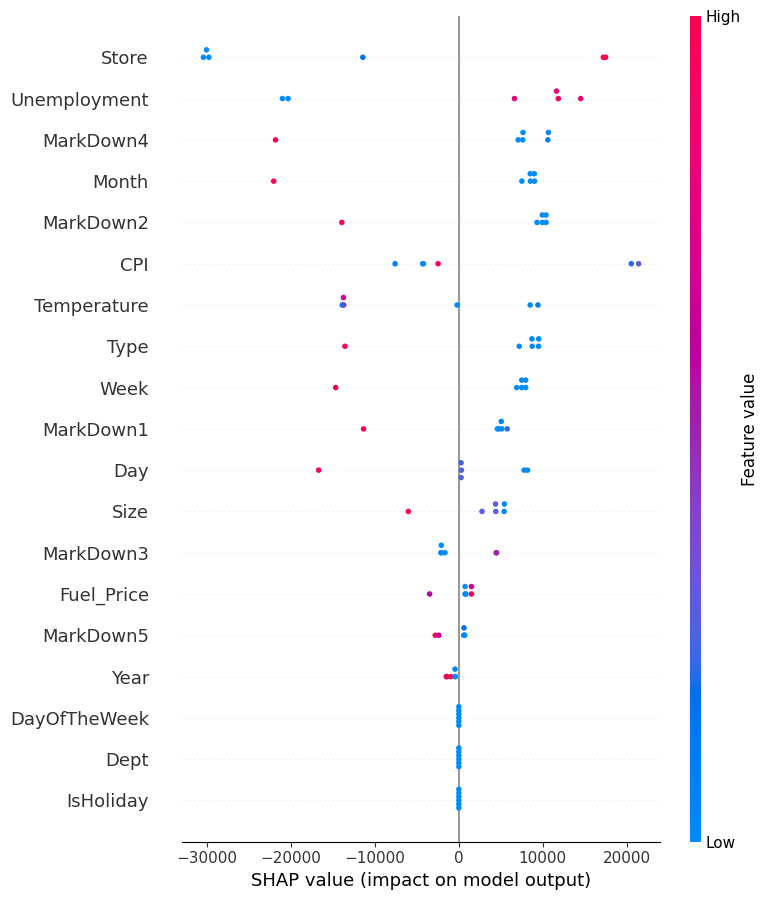

In [59]:

shap.summary_plot(shap_values, X)

In [67]:
top_2_features = features.head(2)['feature'].tolist()

print(top_2_features)

['Store', 'Temperature']


In [68]:
# Get SHAP values for top 2 features
top_shap_values = shap_values[:, [X.columns.get_loc(f) for f in top_2_features]]

# Format as string
shap_values_str = str(top_shap_values.tolist())

In [69]:
!pip install openai

In [70]:
normal_df_stats = df.describe().to_markdown()



In [71]:
prompt = f"""The dataset contains anomalies these are stats for normal df
{normal_df_stats}
then anomalies were detected and the shap values for the anomalies
{shap_values_str}
write statement for the cause of anamolies for the following feature based on above stats

START OF EXAMPLE STATEMENT
For example there is 50% decline in sales value due to fuel price increase
END OF EXAMPLE STATEMENT

WRITE STATEMENTS FOR FOLLOWING FEATURES ONLY

{top_2_features}"""

In [72]:
print(prompt)

The dataset contains anomalies these are stats for normal df
|       |      IsHoliday |        Dept |   Weekly_Sales |   Temperature |    Fuel_Price |   MarkDown1 |   MarkDown2 |   MarkDown3 |   MarkDown4 |   MarkDown5 |         CPI |   Unemployment |          Type |     Size |
|:------|---------------:|------------:|---------------:|--------------:|--------------:|------------:|------------:|------------:|------------:|------------:|------------:|---------------:|--------------:|---------:|
| count | 421570         | 421570      |      421570    |   421570      | 421570        |   421570    |  421570     |  421570     |   421570    |   421570    | 421570      |   421570       | 421570        | 421570   |
| mean  |      0.0703584 |     44.2603 |       15981.3  |       60.0901 |      3.36103  |     2590.07 |     879.974 |     468.088 |     1083.13 |     1662.77 |    171.202  |        7.96029 |      2.41009  | 136728   |
| std   |      0.25575   |     30.4921 |       22711.2  |       18.

In [84]:
import os
os.environ["OPENAI_API_KEY"] = "sk-"

In [85]:
import openai
conversation =  [
            {
            "role": "system",
            "content": "You are a data analyst working on a sales prediction model. A client has provided you with a dataset containing various features and their corresponding weekly sales. You have trained a machine learning model and computed permuattion importance values to understand the impact of each feature on the sales predictions. The client has requested statistical statements based on the SHAP values for given data points. Generate informative responses that explain the statistical relationship between the features and the predicted weekly sales based on the provided data and importance values."
            },
            {
            "role": "user",
            "content": prompt
            }
        ]
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=conversation,
    temperature=0,
    max_tokens=1500,
)
print( response.choices[0].message.content)

RateLimitError: ignored

### USing auto encoder model

In [ ]:
# Splitting data into training and testing sets
X = df3.drop(["anomaly","scores","Weekly_Sales"],axis=1)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,
2012-08-03,0,29.0,5741.51,73.41,3.819,36466.80,220.13,41.77,16284.94,2242.89,138.173581,8.193,3,203819
2011-02-11,1,27.0,2615.95,51.30,3.381,0.00,0.00,0.00,0.00,0.00,127.859129,14.021,2,112238
2012-04-20,0,92.0,88358.68,66.73,4.222,5343.29,3895.86,17.32,657.56,4674.67,131.117333,11.627,3,206302
2011-11-11,0,5.0,22388.56,47.13,3.719,9727.57,4267.72,617.98,1236.64,2067.74,136.461806,7.866,2,123737
2011-12-09,0,13.0,30546.27,17.05,3.331,2782.39,120.00,141.21,1946.76,9503.64,195.874257,6.759,3,196321


In [ ]:
X_test.head()

,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,
2011-11-25,1,60.0,61.60,31.07,3.536,362.32,9.00,44999.94,0.00,660.57,136.478800,7.598,3,152513
2011-02-11,1,79.0,8461.20,43.57,3.022,0.00,0.00,0.00,0.00,0.00,216.266091,7.551,2,37392
2010-09-10,1,7.0,10383.73,57.24,2.780,0.00,0.00,0.00,0.00,0.00,190.395829,6.868,2,57197
2012-05-04,0,38.0,59808.85,52.14,4.124,19129.69,192.00,195.04,5860.88,4953.15,138.033200,8.983,3,203819
2012-01-13,0,96.0,2483.83,27.49,3.077,1934.80,14627.46,112.20,542.89,4044.44,196.733052,6.589,3,196321


In [ ]:
from keras.layers import Bidirectional, LSTM, RepeatVector, TimeDistributed, Dense
from keras.models import Sequential
from keras.optimizers import Adam

n_units = 125  # Number of LSTM units
# Define LSTM Autoencoder model
model = Sequential()
model.add(Bidirectional(
    LSTM(n_units, activation='relu', input_shape=(1, n_features), return_sequences=False))
)  # Encoder
model.add(RepeatVector(1))  # Repeat the compressed representation
model.add(Bidirectional(
    LSTM(n_units, activation='relu', return_sequences=True))
)  # Decoder

model.add(TimeDistributed(Dense(n_features)))  # Reconstruction layer
# Define the optimizer with a custom learning rate
learning_rate = 0.0001  # Set your desired learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mse')



In [ ]:
history = model.fit(
    X_train,
    X_train,  # Notice we are using X_train here
    epochs=30,
    batch_size=32,
    verbose=1,
    validation_data=(X_test, X_test)  # And X_test here
)


Epoch 1/30
2108/2108 [==============================] - 30s 14ms/step - loss: 103638.5625 - val_loss: 105812.3984
Epoch 2/30
2108/2108 [==============================] - 31s 14ms/step - loss: 72514.8203 - val_loss: 38782.1211
Epoch 3/30
2108/2108 [==============================] - 29s 14ms/step - loss: 35355.6602 - val_loss: 35746.1680
Epoch 4/30
2108/2108 [==============================] - 33s 16ms/step - loss: 54069.6328 - val_loss: 13332.5811
Epoch 5/30
2108/2108 [==============================] - 29s 14ms/step - loss: 21582.3906 - val_loss: 26980.4648
Epoch 6/30
2108/2108 [==============================] - 29s 14ms/step - loss: 20282.2031 - val_loss: 7989.5039
Epoch 7/30
2108/2108 [==============================] - 30s 14ms/step - loss: 36838.4961 - val_loss: 5837.8901
Epoch 8/30
2108/2108 [==============================] - 29s 14ms/step - loss: 14124.0596 - val_loss: 10874.0986
Epoch 9/30
2108/2108 [==============================] - 28s 13ms/step - loss: 67878.3203 - val_loss: 632

In [ ]:
X = X.values.reshape((X.shape[0], 1, n_features))

In [ ]:
feature_names = ["IsHoliday", "Dept", "Temperature",
                 "Fuel_Price", "MarkDown1", "MarkDown2",
                 "MarkDown3", "MarkDown4", "MarkDown5",
                 "CPI", "Unemployment", "Type", "Size"]

import numpy as np
from sklearn.metrics import mean_squared_error

# Define a function to calculate reconstruction error
def reconstruction_error(model, data):
    predictions = model.predict(data)
    mse = np.mean(np.power(data - predictions, 2), axis=1)
    return mse

# Calculate baseline reconstruction error without any shuffling
baseline_error = reconstruction_error(model, X)

# Calculation of feature importance
feature_importance = {}

for i in range(X.shape[2]):
    X_shuffled = X.copy()
    np.random.shuffle(X_shuffled[:, 0, i])
    shuffled_error = reconstruction_error(model, X_shuffled)
    score = np.mean(np.abs(shuffled_error - baseline_error))
    feature_importance[feature_names[i]] = score





2635/2635 [==============================] - 16s 6ms/step


In [ ]:
import pandas as pd

# Convert sorted features to DataFrame
feature_df = pd.DataFrame(list(feature_importance.items()), columns=['feature', 'importance'])



In [ ]:
feature_df = feature_df.sort_values(by='importance', ascending=False)

In [ ]:
feature_df

,feature,importance
0,Size,2.982742e+06
1,MarkDown1,1.546027e+06
2,MarkDown3,1.384505e+06
3,MarkDown4,1.102735e+06
4,MarkDown2,8.858099e+05
5,MarkDown5,6.536578e+05
6,CPI,4.058998e+02
7,Dept,2.807613e+02
8,Temperature,1.674556e+02
9,Unemployment,1.972422e+01


In [ ]:
top_n_features = feature_df.head(2).to_markdown()

In [ ]:
prompt = f"""The dataset contains anomalies these are stats for normal df
{normal_df_stats}
then anomalies were detected and the stats for anomalies are
{anomalies_df_stats}
write statement for the cause of anamolies for the following feature based on above stats

START OF EXAMPLE STATEMENT
For example there is 50% decline in sales value due to fuel price increase
END OF EXAMPLE STATEMENT

WRITE STATEMENTS FOR FOLLOWING FEATURES ONLY

{top_n_features}"""

In [ ]:
prompt

'The dataset contains anomalies these are stats for normal df\n|       |      IsHoliday |        Dept |   Weekly_Sales |   Temperature |    Fuel_Price |   MarkDown1 |   MarkDown2 |   MarkDown3 |   MarkDown4 |   MarkDown5 |         CPI |   Unemployment |          Type |     Size |\n|:------|---------------:|------------:|---------------:|--------------:|--------------:|------------:|------------:|------------:|------------:|------------:|------------:|---------------:|--------------:|---------:|\n| count | 421570         | 421570      |      421570    |   421570      | 421570        |   421570    |  421570     |  421570     |   421570    |   421570    | 421570      |   421570       | 421570        | 421570   |\n| mean  |      0.0703584 |     44.2603 |       15981.3  |       60.0901 |      3.36103  |     2590.07 |     879.974 |     468.088 |     1083.13 |     1662.77 |    171.202  |        7.96029 |      2.41009  | 136728   |\n| std   |      0.25575   |     30.4921 |       22711.2  |    

In [ ]:
import openai
conversation =  [
            {
            "role": "system",
            "content": "You are a data analyst working on a sales prediction model. A client has provided you with a dataset containing various features and their corresponding weekly sales. You have trained a machine learning model and computed permuattion importance values to understand the impact of each feature on the sales predictions. The client has requested statistical statements based on the SHAP values for given data points. Generate informative responses that explain the statistical relationship between the features and the predicted weekly sales based on the provided data and importance values."
            },
            {
            "role": "user",
            "content": prompt
            }
        ]
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=conversation,
    temperature=0,
    max_tokens=1500,
)
print( response.choices[0].message.content)

Based on the provided statistics and importance values, we can make the following statements about the causes of anomalies for the given features:

1. Size:
   - The Size feature has a high importance value of 2.98274e+06, indicating that it has a significant impact on the weekly sales predictions.
   - An increase or decrease in store size can lead to a corresponding increase or decrease in weekly sales.
   - Larger store sizes tend to have higher weekly sales, while smaller store sizes tend to have lower weekly sales.
   - Anomalies in the Size feature may be caused by sudden changes in store sizes, such as store expansions or closures.

2. MarkDown1:
   - The MarkDown1 feature has a relatively high importance value of 1.54603e+06, suggesting that it also has a significant influence on the weekly sales predictions.
   - MarkDown1 refers to promotional markdowns applied to products.
   - An increase in MarkDown1 values can lead to higher weekly sales, as customers are more likely to p